#création d'un modèle de classification un modèle de régression à l’aide de pipelines.

In [ ]:
!pip install sparkmagic
!pip install pyspark

* Entrainement d'un modèle LogisticRegression avec un Pipleline préparant les données
* Une crossvalidation pour régler les paramètres du modèle
* Une classification binaire (0 ou 1) pour évaluer notre modèle entraîné.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['data', 'sys', 'mnt', 'tmp', 'opt', 'lost+found', 'copyright', 'lib32', 'lib64', 'etc', 'proc', 'root', 'srv', 'libx32', 'census_training', 'localfile', 'sbin', 'boot', 'dev', 'media', 'airports.csv', 'flights.csv', 'hadoop', 'lib', 'home', 'run', 'var', 'bin', 'usr']


In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
#from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.appName("nvkaggle").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/02/21 15:27:44 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/02/21 15:27:44 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/02/21 15:27:44 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/02/21 15:27:45 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


Quand on est sur un cluster, on ne peut pas récupérer les data facilement (Quand je le fais avec spark ça ne fonctionne pas), j'ai donc utilisé 2 méthodes pour les récupérer :

* créer le fichier flights.csv dans le répertoire courant du cluster en le récupérant d'une bucket puis lire ce fichier via pandas

* directement lire le csv contenu dans le bucket avec pandas

(commande de base qui ne fonctionne pas avec le cluster: csv = spark.read.csv('../input/flights.csv', inferSchema=True, header=True))

In [ ]:
!gsutil cp gs://{'nvkaggle'}/flights.csv flights.csv

Copying gs://nvkaggle/flights.csv...
- [1 files][ 68.8 MiB/ 68.8 MiB]                                                
Operation completed over 1 objects/68.8 MiB.                                     


In [ ]:
!ls

airports.csv	 copyright  flights.csv  lib32	    lost+found	proc  srv  var
bin		 data	    hadoop	 lib64	    media	root  sys
boot		 dev	    home	 libx32     mnt		run   tmp
census_training  etc	    lib		 localfile  opt		sbin  usr


Comme expliqué je passe donc par une dataframe pandas quand j'ai des erreurs lorsque je fais : 

In [ ]:
import pandas
df = pd.read_csv('flights.csv')

In [ ]:
type(df)

On passe ensuite d'un dataframe panda à un dataframe spark

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sqlfunc
from pyspark.sql.types import *
import argparse, sys
from pyspark.sql import *
import pyspark.sql.functions as sqlfunc
import pandas as pd

def create_session(appname):
    spark_session = SparkSession\
        .builder\
        .appName(appname)\
        .master('yarn')\
        .config("hive.metastore.uris", "thrift://uds-far-mn1.dab.02.net:9083")\
        .enableHiveSupport()\
        .getOrCreate()
    return spark_session
### START MAIN ###
if __name__ == '__main__':
    spark_session = create_session('testing_files')

In [ ]:
from pyspark.sql import SparkSession
# Pandas to Spark
csv = spark_session.createDataFrame(df)

In [ ]:
type(csv)

Les données du fichier flights.csv contient des infos spécifiques pour chaque vol, ainsi qu’une colonne indiquant combien de minutes de retard ou d’avance le vol est arrivé.

In [ ]:
csv.show(10)

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|        19|        5|     DL|          11433|        13303|      -3|       1|
|        19|        5|     DL|          14869|        12478|       0|      -8|
|        19|        5|     DL|          14057|        14869|      -4|     -15|
|        19|        5|     DL|          15016|        11433|      28|      24|
|        19|        5|     DL|          11193|        12892|      -6|     -11|
|        19|        5|     DL|          10397|        15016|      -1|     -19|
|        19|        5|     DL|          15016|        10397|       0|      -1|
|        19|        5|     DL|          10397|        14869|      15|      24|
|        19|        5|     DL|          10397|        10423|      33|      34|
|        19|        5|     DL|          11278|      

23/02/21 15:31:26 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


# Préparation des données pour un modèle de classification (modèle d'apprentissage d'arbre de décision)
* Séléction d'un sous-ensemble de colonnes à utiliser comme fonctionnalités et labéliser (0 ou 1 )
  * 1 = vol arrivé en retard
  * 0 pour un vol en avance ou à l'heure

In [ ]:
data = csv.select("DayofMonth", "DayOfWeek", "Carrier", "OriginAirportID", "DestAirportID", "DepDelay", ((col("ArrDelay") > 15).cast("Int").alias("label")))
data.show(10)

23/02/21 15:31:27 WARN org.apache.spark.scheduler.TaskSetManager: Stage 2 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


+----------+---------+-------+---------------+-------------+--------+-----+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|label|
+----------+---------+-------+---------------+-------------+--------+-----+
|        19|        5|     DL|          11433|        13303|      -3|    0|
|        19|        5|     DL|          14869|        12478|       0|    0|
|        19|        5|     DL|          14057|        14869|      -4|    0|
|        19|        5|     DL|          15016|        11433|      28|    1|
|        19|        5|     DL|          11193|        12892|      -6|    0|
|        19|        5|     DL|          10397|        15016|      -1|    0|
|        19|        5|     DL|          15016|        10397|       0|    0|
|        19|        5|     DL|          10397|        14869|      15|    1|
|        19|        5|     DL|          10397|        10423|      33|    1|
|        19|        5|     DL|          11278|        10397|     323|    1|
+----------+

* Train: 70 % 
* Test 30 %  (label = TrueLabel)

In [ ]:
splits = data.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1].withColumnRenamed("label", "trueLabel")
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)

23/02/21 15:31:27 WARN org.apache.spark.scheduler.TaskSetManager: Stage 3 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:31:32 WARN org.apache.spark.scheduler.TaskSetManager: Stage 6 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


Training Rows: 1891792  Testing Rows: 810426


In [ ]:
test.show(10)

23/02/21 15:31:35 WARN org.apache.spark.scheduler.TaskSetManager: Stage 9 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


+----------+---------+-------+---------------+-------------+--------+---------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|trueLabel|
+----------+---------+-------+---------------+-------------+--------+---------+
|         1|        1|     9E|          10397|        12264|      23|        0|
|         1|        1|     9E|          10397|        13851|       2|        0|
|         1|        1|     9E|          10423|        11433|      14|        1|
|         1|        1|     9E|          10423|        13487|      -7|        0|
|         1|        1|     9E|          10423|        13487|      -2|        0|
|         1|        1|     9E|          10423|        14869|     -10|        0|
|         1|        1|     9E|          10529|        11193|      -5|        0|
|         1|        1|     9E|          10529|        11193|      -5|        0|
|         1|        1|     9E|          10529|        13487|      -4|        1|
|         1|        1|     9E|          

# Pipeline à 7 étapes 
series de transformer et estimator afin de former un modèle prédictif.

* StringIndexer : Convertit les valeurs de chaîne en index pour les caractéristiques catégorielles
* VectorAssembler : Combine des caractéristiques catégorielles en un seul vecteur
* VectorIndexer : Crée des index pour un vecteur de caractéristiques catégorielles
* VectorAssembler : Crée un vecteur d'entités numériques continues
* MinMaxScaler : Normalise les caractéristiques numériques continues
* VectorAssembler : Crée un vecteur de caractéristiques catégorielles et continues
* LogisticRegression : Entraîne un modèle de régréssion 
* DecisionTreeClassifier : Entraîne un modèle de classification. (ici pas utilisé)

In [ ]:
strIdx = StringIndexer(inputCol = "Carrier", outputCol = "CarrierIdx")
catVect = VectorAssembler(inputCols = ["CarrierIdx", "DayofMonth", "DayOfWeek", "OriginAirportID", "DestAirportID"], outputCol="catFeatures")
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "idxCatFeatures")
numVect = VectorAssembler(inputCols = ["DepDelay"], outputCol="numFeatures")
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["idxCatFeatures", "normFeatures"], outputCol="features")
lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter=10,regParam=0.3)
#dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[strIdx, catVect, catIdx, numVect, minMax, featVect, lr])

Execution du pipeline sur les données "train" (70%)

In [ ]:
piplineModel = pipeline.fit(train)

23/02/21 15:31:37 WARN org.apache.spark.scheduler.TaskSetManager: Stage 10 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:31:43 WARN org.apache.spark.scheduler.TaskSetManager: Stage 13 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:31:47 WARN org.apache.spark.scheduler.TaskSetManager: Stage 14 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:31:52 WARN org.apache.spark.scheduler.TaskSetManager: Stage 17 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:31:59 WARN org.apache.spark.scheduler.TaskSetManager: Stage 18 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:32:07 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/21 15:32:07 

Génération des labels sur la base de test

In [ ]:
prediction = piplineModel.transform(test)
predicted = prediction.select("features", "prediction", "trueLabel")
predicted.show(100, truncate=False)

23/02/21 15:32:14 WARN org.apache.spark.scheduler.TaskSetManager: Stage 30 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


+---------------------------------------------------+----------+---------+
|features                                           |prediction|trueLabel|
+---------------------------------------------------+----------+---------+
|[10.0,1.0,0.0,10397.0,12264.0,0.043523859465128475]|0.0       |0        |
|[10.0,1.0,0.0,10397.0,13851.0,0.032511798636601995]|0.0       |0        |
|[10.0,1.0,0.0,10423.0,11433.0,0.03880440482433141] |0.0       |1        |
|[10.0,1.0,0.0,10423.0,13487.0,0.02779234399580493] |0.0       |0        |
|[10.0,1.0,0.0,10423.0,13487.0,0.030414263240692185]|0.0       |0        |
|[10.0,1.0,0.0,10423.0,14869.0,0.026219192448872573]|0.0       |0        |
|[10.0,1.0,0.0,10529.0,11193.0,0.028841111693759833]|0.0       |0        |
|[10.0,1.0,0.0,10529.0,11193.0,0.028841111693759833]|0.0       |0        |
|[10.0,1.0,0.0,10529.0,13487.0,0.029365495542737284]|0.0       |1        |
|[10.0,1.0,0.0,10529.0,14492.0,0.04195070791819612] |0.0       |1        |
|[10.0,1.0,0.0,10693.0,12

Calcule de la matrice de confusion et la zone sous ROC (Receiver Operating Characteristic) pour évaluer le modèle.

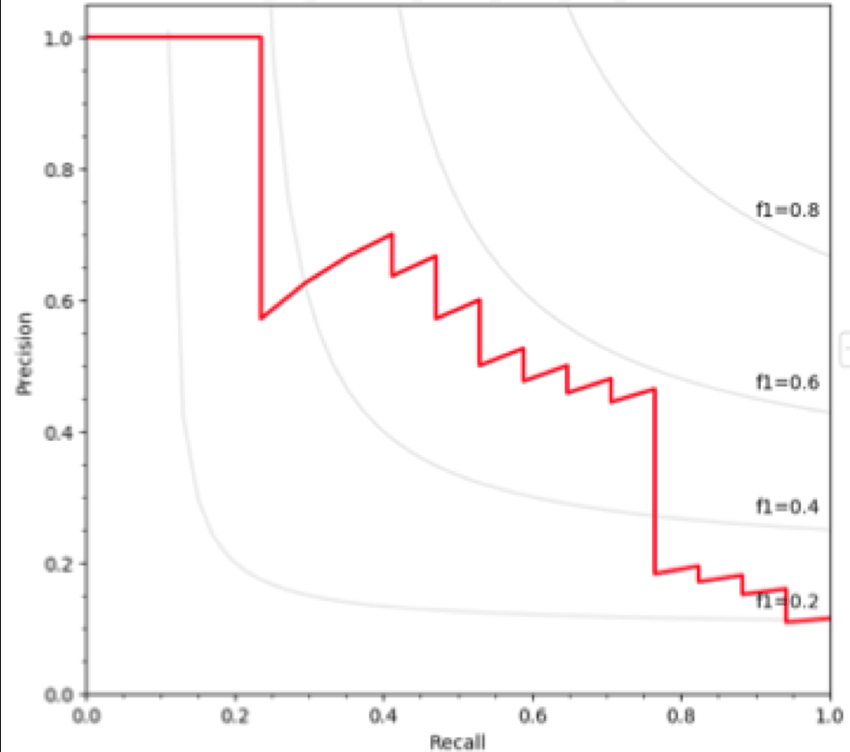

In [ ]:
tp = float(predicted.filter("prediction == 1.0 AND truelabel == 1").count())
fp = float(predicted.filter("prediction == 1.0 AND truelabel == 0").count())
tn = float(predicted.filter("prediction == 0.0 AND truelabel == 0").count())
fn = float(predicted.filter("prediction == 0.0 AND truelabel == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

23/02/21 15:32:16 WARN org.apache.spark.scheduler.TaskSetManager: Stage 31 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:32:21 WARN org.apache.spark.scheduler.TaskSetManager: Stage 34 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:32:25 WARN org.apache.spark.scheduler.TaskSetManager: Stage 37 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:32:30 WARN org.apache.spark.scheduler.TaskSetManager: Stage 40 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            19197.0|
|       FP|               77.0|
|       TN|           649061.0|
|       FN|           142091.0|
|Precision| 0.9960049808031545|
|   Recall|0.11902311393284064|
|       F1|0.21263610283448345|
+---------+-------------------+



On cherche à minimiser FP (cas ou on dit qu'un avion est à l'heure alors qu'il est en retard)

* Bonne précision
* Faible rappel
* F1 pas très bon.

Le score AUC semble indiquer un modèle raisonnablement bon, mais les mesures de performance semblent indiquer qu'il prédit un nombre élevé d'étiquettes faux négatifs (c'est-à-dire qu'il prédit 0 lorsque la véritable étiquette est 1), ce qui entraîne un faible rappel. Nous pouvons améliorer cela en abaissant le seuil. À l'inverse, parfois, nous pouvons vouloir traiter un grand nombre de faux positifs en augmentant le seuil.


In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
aur = evaluator.evaluate(prediction)
print ("AUR = ", aur)

23/02/21 15:32:35 WARN org.apache.spark.scheduler.TaskSetManager: Stage 45 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


AUR =  0.9148013320164919


La courbe ROC montre les taux de vrais positifs et de faux positifs tracés pour différents seuils.

In [ ]:
prediction.select("rawPrediction", "probability", "prediction", "trueLabel").show(100, truncate=False)

23/02/21 15:32:47 WARN org.apache.spark.scheduler.TaskSetManager: Stage 56 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


+------------------------------------------+----------------------------------------+----------+---------+
|rawPrediction                             |probability                             |prediction|trueLabel|
+------------------------------------------+----------------------------------------+----------+---------+
|[1.1299563537468855,-1.1299563537468855]  |[0.75583084424345,0.24416915575654996]  |0.0       |0        |
|[1.4787795640156531,-1.4787795640156531]  |[0.8143881702874026,0.18561182971259738]|0.0       |0        |
|[1.2243920982974605,-1.2243920982974605]  |[0.7728355534125942,0.22716444658740576]|0.0       |1        |
|[1.5905111641895897,-1.5905111641895897]  |[0.8306880081319611,0.1693119918680389] |0.0       |0        |
|[1.5214523713267165,-1.5214523713267165]  |[0.8207522500961268,0.17924774990387315]|0.0       |0        |
|[1.6831303210025719,-1.6831303210025719]  |[0.843318592418896,0.15668140758110405] |0.0       |0        |
|[1.48162425523468,-1.48162425523468]

vecteur = [proba 0, proba 1]

seuil = 0,5

beaucoup d'erreur quand le seuil est proche exemple ⁉[0.5818036457014308,0.41819635429856916]|pred :0.0       |reel :1        |

#Tuning
Clossvalidation pour tester différents paramètre à notre modèle.

Cela peut prendre beaucoup de temps car chaque combinaison de paramètres est essayée plusieurs fois.


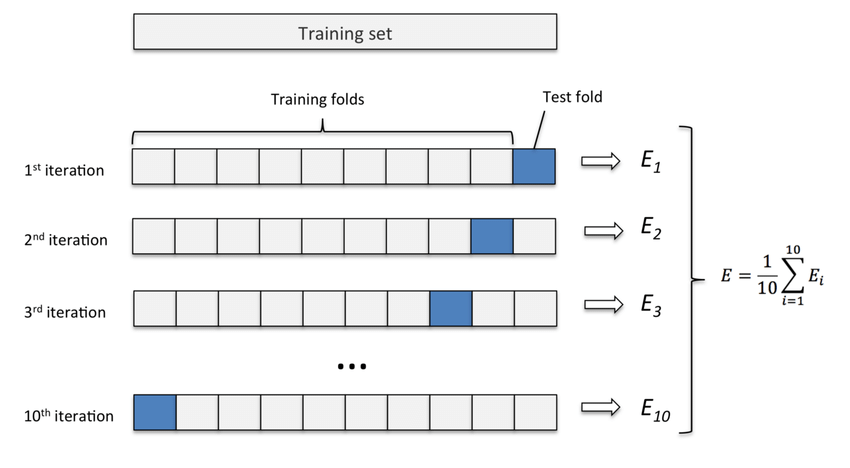

In [ ]:
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.1]).addGrid(lr.maxIter, [10, 5]).addGrid(lr.threshold, 
                                                                                            [0.4, 0.3]).build()
cv = CrossValidator(estimator=pipeline, evaluator=BinaryClassificationEvaluator(), estimatorParamMaps=paramGrid, 
                    numFolds=2)

model = cv.fit(train)

23/02/21 15:32:49 WARN org.apache.spark.scheduler.TaskSetManager: Stage 57 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:32:53 WARN org.apache.spark.scheduler.TaskSetManager: Stage 60 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:32:54 WARN org.apache.spark.scheduler.TaskSetManager: Stage 61 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:32:56 WARN org.apache.spark.scheduler.TaskSetManager: Stage 64 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:32:58 WARN org.apache.spark.scheduler.TaskSetManager: Stage 65 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:33:01 WARN org.apache.spark.scheduler.TaskSetManager: Stage 66 contains a task of very large size (29432 KiB). The maximum recommended tas

CrossValidator permet de trouver le meilleur seuil entre 0.45, 0.4 et 0.35, le paramètre de régularisation entre 0.3 et 0.1, et le nombre maximum d'itérations autorisées entre 10 et 5.

In [ ]:
newPrediction = model.transform(test)
newPredicted = prediction.select("features", "prediction", "trueLabel")
newPredicted.show()

23/02/21 15:38:34 WARN org.apache.spark.scheduler.TaskSetManager: Stage 533 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------+---------+
|            features|prediction|trueLabel|
+--------------------+----------+---------+
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        1|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,105...|       0.0|        0|
|[10.0,1.0,0.0,105...|       0.0|        0|
|[10.0,1.0,0.0,105...|       0.0|        1|
|[10.0,1.0,0.0,105...|       0.0|        1|
|[10.0,1.0,0.0,106...|       1.0|        1|
|[10.0,1.0,0.0,106...|       0.0|        0|
|[10.0,1.0,0.0,107...|       0.0|        1|
|[10.0,1.0,0.0,107...|       0.0|        1|
|[10.0,1.0,0.0,107...|       0.0|        1|
|[10.0,1.0,0.0,107...|       0.0|        1|
|[10.0,1.0,0.0,108...|       0.0|        0|
|[10.0,1.0,0.0,108...|       0.0|        0|
|[10.0,1.0,0.0,108...|       0.0|        1|
|[10.0,1.0,0.0,108...|       0.0

In [ ]:
# Recalculate confusion matrix
tp2 = float(newPrediction.filter("prediction == 1.0 AND truelabel == 1").count())
fp2 = float(newPrediction.filter("prediction == 1.0 AND truelabel == 0").count())
tn2 = float(newPrediction.filter("prediction == 0.0 AND truelabel == 0").count())
fn2 = float(newPrediction.filter("prediction == 0.0 AND truelabel == 1").count())
pr2 = tp2 / (tp2 + fp2)
re2 = tp2 / (tp2 + fn2)
metrics2 = spark.createDataFrame([
 ("TP", tp2),
 ("FP", fp2),
 ("TN", tn2),
 ("FN", fn2),
 ("Precision", pr2),
 ("Recall", re2),
 ("F1", 2*pr2*re2/(re2+pr2))],["metric", "value"])
metrics2.show()

23/02/21 15:38:35 WARN org.apache.spark.scheduler.TaskSetManager: Stage 534 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:38:40 WARN org.apache.spark.scheduler.TaskSetManager: Stage 537 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:38:45 WARN org.apache.spark.scheduler.TaskSetManager: Stage 540 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.
23/02/21 15:38:49 WARN org.apache.spark.scheduler.TaskSetManager: Stage 543 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|           88736.0|
|       FP|            2589.0|
|       TN|          646549.0|
|       FN|           72552.0|
|Precision| 0.971650698056392|
|   Recall|0.5501711224641634|
|       F1|0.7025449996635169|
+---------+------------------+



FN beaucoup plus petit :
* 142091 --> 72552

Ce qui forcément fait passer FP 
* 77 --> 2589

In [ ]:
# Recalculate the Area Under ROC
evaluator2 = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
aur2 = evaluator.evaluate(prediction)
print( "AUR2 = ", aur2)

23/02/21 15:38:54 WARN org.apache.spark.scheduler.TaskSetManager: Stage 548 contains a task of very large size (29432 KiB). The maximum recommended task size is 1000 KiB.


AUR2 =  0.9148013793286851



Amélioration sans compromettre les autres mesures:
* rappel
* score F1  

Je supprime ici flights.csv que j'ai crée dans répertoire courant 

In [ ]:
!rm flights.csv